In [1]:
import os
from os import path
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
from scipy.io import loadmat
from skimage import io
import imutils
from tqdm import tqdm


from PIL import Image


import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision


CURRENT_DIR = path.abspath(path.curdir)
FOLDER = '/[EG_code_data]_release/data/'
IMG_SIZE = (100,100)

urls = pd.read_csv(CURRENT_DIR + FOLDER + 'alldata_urls.txt',names=['name','url'],delimiter=' ')
crops = pd.read_csv(CURRENT_DIR + FOLDER + 'crop.txt',names=['name','leftx','lefty','rightx','righty'],delimiter=' ')
trainlist = list(loadmat(CURRENT_DIR + FOLDER + 'trainlist')["trainlist"][0])
testlist = list(loadmat(CURRENT_DIR + FOLDER + 'testlist')["testlist"][0])

img_transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.75)
    ,transforms.ToTensor()
    ,transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [2]:
for sample in tqdm(urls.T.iteritems()):
    
    try:
        og = io.imread(sample[1][1])
        crop = crops[crops['name']==sample[1][0]]
        og = og[crop['leftx'].values[0]:crop['lefty'].values[0],crop['rightx'].values[0]:crop['righty'].values[0],:]
        og = cv2.resize(og,IMG_SIZE)
        og = cv2.cvtColor(og, cv2.COLOR_BGR2RGB)
        
        if int(sample[1][0].split('.')[0]) in testlist:
            traintest = 'test'

        elif int(sample[1][0].split('.')[0]) in trainlist:
            traintest = 'train'
            
        else:
            traintest = 'neither'
        
 
        

        # Grabbing the image and mask from the dataset
        image = og.copy()
        mask = np.asarray(loadmat(CURRENT_DIR + FOLDER + '/images_mask/' + sample[1][0].split('.')[0] + '_mask.mat')['mask'])
        mask = cv2.resize(mask,IMG_SIZE)
        

        inv_mask = cv2.bitwise_not(mask) - 254

        data = image.copy()

        # Saving the results to a file
        
        ret, thresh = cv2.threshold(mask,127,255,0)
        contours,hierarchy = cv2.findContours(mask, 1, 2)
        trimap = cv2.drawContours(np.zeros((IMG_SIZE[1],IMG_SIZE[0])), contours, -1,(255),thickness=-1)

        trimap = cv2.drawContours(trimap,contours,-1,(127),thickness=1)
        kernel = np.ones((5,5),np.uint8)
        trimap = cv2.erode(trimap,kernel,iterations=3)
        trimap = cv2.dilate(trimap,kernel,iterations=3)
        

        
        background_channel = np.where(trimap==0,float(1),0)
        uncertain_channel = np.where(trimap==127,float(1),0)
        foreground_channel = np.where(trimap==255,float(1),0)
        trimap = cv2.merge((background_channel,uncertain_channel,foreground_channel))

        cv2.imwrite(os.path.join(CURRENT_DIR,'data2',traintest,'data_' + sample[1][0].split('.')[0] + '.png'),data)
        cv2.imwrite(os.path.join(CURRENT_DIR,'matte2',traintest,'matte_' + sample[1][0].split('.')[0] + '.png'),mask)
        cv2.imwrite(os.path.join(CURRENT_DIR,'trimap2',traintest,'trimap_' + sample[1][0].split('.')[0] + '.png'),trimap)


    except Exception as e:

#         print(e)
        pass

    

print(len(os.listdir(CURRENT_DIR + '/data2/train/')) + len(os.listdir(CURRENT_DIR + '/data2/test/'))) 

1879it [12:29,  2.51it/s]

1494


In [2]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)
    
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)
    
class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = torch.tensor([x2.size()[2] - x1.size()[2]])
        diffX = torch.tensor([x2.size()[3] - x1.size()[3]])
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat((x1,x2),1)
        x = self.conv(x)
        return x
    
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
    
    
class GluNet(nn.Module):
    def __init__(self, bilinear=True):
        super(GluNet, self).__init__()
        self.bilinear = bilinear

        self.inc = DoubleConv(3, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256,512)
        self.down4 = Down(512,512)
        self.up1 = Up(1024, 256, bilinear)
        self.up2 = Up(512, 128, bilinear)
        self.up3 = Up(256,64, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64,3)
        
        self.inc1 = DoubleConv(6, 64)
        self.down1_1 = Down(64, 128)
        self.down2_1 = Down(128, 256)
        self.down3_1 = Down(256,512)
        self.down4_1 = Down(512,512)
        self.up1_1 = Up(1024, 256, bilinear)
        self.up2_1 = Up(512, 128, bilinear)
        self.up3_1 = Up(256,64, bilinear)
        self.up4_1 = Up(128, 64, bilinear)
        self.outc1 = OutConv(64,1)
        


    def forward(self, image):
        
        
        
        x1 = self.inc(image)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x4,x5)
        x = self.up2(x,x3)
        x = self.up3(x,x2)
        x = self.up4(x,x1)
        
        trimap = F.softmax(self.outc(x),dim=1)
        x = torch.cat((image,trimap),1)


        x1 = self.inc1(x)
        x2 = self.down1_1(x1)
        x3 = self.down2_1(x2)
        x4 = self.down3_1(x3)
        x5 = self.down4_1(x4)
        x = self.up1_1(x4,x5)
        x = self.up2_1(x,x3)
        x = self.up3_1(x,x2)
        x = self.up4_1(x,x1)

        matte = torch.sigmoid(self.outc1(x))

        return trimap, matte

In [3]:
class ImageDataset(Dataset):

    def __init__(self,test=False,transform=None):
        self.root = path.abspath(path.curdir)
        self.transform = transform
        self.traintest = 'test' if test else 'train'
        self.data = os.listdir(self.root + f'/data2/{self.traintest}/')
        
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self,index):

        if torch.is_tensor(index):
            index = index.tolist()

        item = Image.open(self.root + f'/data2/{self.traintest}/' + self.data[index])
        trimap = Image.open(self.root + f'/trimap2/{self.traintest}/' + self.data[index].replace("data","trimap"))
        matte = Image.open(self.root + f'/matte2/{self.traintest}/' + self.data[index].replace("data","matte"))
        
        
        rotation = np.random.randint(-30,31)
        item = item.rotate(rotation)
        trimap = trimap.rotate(rotation)
        matte = matte.rotate(rotation)
        
        x1, y1, x2, y2 = np.random.randint(0,26), np.random.randint(0,26), 100 - np.random.randint(0,26), 100-np.random.randint(0,26)
        
        item = item.crop((x1,y1,x2,y2))
        trimap = trimap.crop((x1,y1,x2,y2))
        matte = matte.crop((x1,y1,x2,y2))
        
        item = item.resize((100,100))
        trimap = trimap.resize((100,100))
        matte = matte.resize((100,100))
        
        
        if self.transform:
            item = self.transform(item)
            trimap = transforms.ToTensor()(trimap)*255
            matte = transforms.ToTensor()(matte)*255

        
        return item, trimap, matte

In [4]:
trainset = ImageDataset(transform=img_transform)

trainloader = DataLoader(
    trainset,
    batch_size=16,
    shuffle=True
    )

In [5]:
class CompositionalLoss(nn.Module):
    
    
    def __init__(self) -> None:
        super(CompositionalLoss, self).__init__()
        self.epsilon: float = 1e-6
        
    def forward(self,output,target):
        
       
        loss = torch.pow(torch.pow(output - target,2) + self.epsilon,0.5)
        
        return torch.mean(loss)

In [6]:
EPOCHS = 400
LR = 0.001
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
CURRENT_DIR = path.abspath(path.curdir)

GNet = GluNet()
GNet.to(DEVICE)
optimizer = optim.Adam(GNet.parameters(),lr=LR)
loss_function = CompositionalLoss()

In [7]:
def train(net,trainloader):
    
    loss_tracker = []
    
    for epoch in range(EPOCHS):
        
        avg_loss = 0
        
        for data in tqdm(trainloader): 
            
            net.zero_grad()
            
            images, trimaps, mattes = data[0].float().to(DEVICE), data[1].float().to(DEVICE), data[2].float().to(DEVICE)


            outputs1, outputs2 = net(images)
            loss = loss_function(outputs1,trimaps) + loss_function(outputs2,mattes)
            loss.backward()
            optimizer.step()
            
            images.cpu()
            trimaps.cpu()
            mattes.cpu()

            avg_loss += loss
            
        avg_loss /= 20592    

        print(f"Epoch: {epoch+1}. Avg Loss: {avg_loss}.")
        
        loss_tracker.append(avg_loss)
        
        torch.save(GNet.state_dict(),CURRENT_DIR + f'/Models/GNET COMP v{epoch+1}')
        
    return loss_tracker

In [8]:
losses = train(GNet,trainloader)

100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [01:39<00:00,  1.28s/it]


Epoch: 1. Avg Loss: 0.0018470524810254574.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 2. Avg Loss: 0.0012973406119272113.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 3. Avg Loss: 0.0011754571460187435.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 4. Avg Loss: 0.0011245307978242636.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 5. Avg Loss: 0.00106012390460819.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 6. Avg Loss: 0.001022024662233889.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 7. Avg Loss: 0.001020491705276072.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 8. Avg Loss: 0.0009815290104597807.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 9. Avg Loss: 0.0009632935980334878.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 10. Avg Loss: 0.0009299470693804324.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 11. Avg Loss: 0.0009523957269266248.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 12. Avg Loss: 0.0009090363164432347.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 13. Avg Loss: 0.0008901962428353727.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 14. Avg Loss: 0.0008750290726311505.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 15. Avg Loss: 0.0008542850846424699.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 16. Avg Loss: 0.0008501067641191185.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 17. Avg Loss: 0.0008355356403626502.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 18. Avg Loss: 0.0007905038655735552.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 19. Avg Loss: 0.0007743168389424682.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 20. Avg Loss: 0.0007965271943248808.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 21. Avg Loss: 0.0007513202726840973.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 22. Avg Loss: 0.0007306853658519685.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 23. Avg Loss: 0.0007050095009617507.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 24. Avg Loss: 0.0007032152498140931.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 25. Avg Loss: 0.0007095514447428286.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 26. Avg Loss: 0.0006996701704338193.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 27. Avg Loss: 0.0007078934577293694.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 28. Avg Loss: 0.0006681532831862569.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 29. Avg Loss: 0.0006834506057202816.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 30. Avg Loss: 0.0006589764379896224.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 31. Avg Loss: 0.0006403920124284923.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 32. Avg Loss: 0.0006276399944908917.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 33. Avg Loss: 0.0006111628608778119.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 34. Avg Loss: 0.0006117845186963677.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 35. Avg Loss: 0.0006088940426707268.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 36. Avg Loss: 0.000590237439610064.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:43<00:00,  1.78it/s]


Epoch: 37. Avg Loss: 0.0005878736265003681.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 38. Avg Loss: 0.0005741360364481807.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 39. Avg Loss: 0.0005573033704422414.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 40. Avg Loss: 0.0005415883497335017.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 41. Avg Loss: 0.0005663341144099832.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 42. Avg Loss: 0.0005408787983469665.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 43. Avg Loss: 0.0005683688796125352.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 44. Avg Loss: 0.0005531364004127681.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 45. Avg Loss: 0.0005557996919378638.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 46. Avg Loss: 0.0005200257292017341.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 47. Avg Loss: 0.0005241347244009376.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 48. Avg Loss: 0.0005059983814135194.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 49. Avg Loss: 0.0004997416981495917.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 50. Avg Loss: 0.0005267153610475361.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 51. Avg Loss: 0.0004951879382133484.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 52. Avg Loss: 0.00048825121484696865.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 53. Avg Loss: 0.0005071510095149279.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 54. Avg Loss: 0.0004879051120951772.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 55. Avg Loss: 0.0005083173746243119.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 56. Avg Loss: 0.0005018333904445171.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 57. Avg Loss: 0.0004760773736052215.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 58. Avg Loss: 0.0004689534252975136.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 59. Avg Loss: 0.0004640545812435448.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 60. Avg Loss: 0.00047337269643321633.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 61. Avg Loss: 0.0004733717069029808.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 62. Avg Loss: 0.0004626384761650115.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 63. Avg Loss: 0.0004579697852022946.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 64. Avg Loss: 0.0004637715173885226.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 65. Avg Loss: 0.0004978544311597943.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 66. Avg Loss: 0.0004790304519701749.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 67. Avg Loss: 0.00044181194971315563.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 68. Avg Loss: 0.0004456409078557044.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 69. Avg Loss: 0.00042925949674099684.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 70. Avg Loss: 0.00042075119563378394.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 71. Avg Loss: 0.000410218519391492.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 72. Avg Loss: 0.0004264414310455322.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 73. Avg Loss: 0.0004146542341914028.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 74. Avg Loss: 0.00042671989649534225.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 75. Avg Loss: 0.0004242191498633474.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 76. Avg Loss: 0.0004245707532390952.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 77. Avg Loss: 0.0004053543962072581.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 78. Avg Loss: 0.00041421144851483405.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 79. Avg Loss: 0.00041700215660966933.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 80. Avg Loss: 0.00041791595867834985.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 81. Avg Loss: 0.00042221814510412514.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 82. Avg Loss: 0.000382469326723367.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 83. Avg Loss: 0.0004080452199559659.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 84. Avg Loss: 0.00040606004768051207.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 85. Avg Loss: 0.0004012576537206769.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 86. Avg Loss: 0.0003964597126469016.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 87. Avg Loss: 0.0004009381227660924.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 88. Avg Loss: 0.0004045862297061831.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 89. Avg Loss: 0.00039571942761540413.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 90. Avg Loss: 0.00038911961019039154.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 91. Avg Loss: 0.0003903414763044566.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 92. Avg Loss: 0.0003784571308642626.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 93. Avg Loss: 0.0003850712673738599.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 94. Avg Loss: 0.0003912296670023352.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 95. Avg Loss: 0.00039212804404087365.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 96. Avg Loss: 0.00038407265674322844.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 97. Avg Loss: 0.0003594622539822012.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 98. Avg Loss: 0.0003570334811229259.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 99. Avg Loss: 0.0003701527020893991.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:45<00:00,  1.72it/s]


Epoch: 100. Avg Loss: 0.0003946590004488826.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 101. Avg Loss: 0.0003588683030102402.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 102. Avg Loss: 0.00038750917883589864.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 103. Avg Loss: 0.00038154609501361847.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 104. Avg Loss: 0.00037076399894431233.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:45<00:00,  1.71it/s]


Epoch: 105. Avg Loss: 0.00037571712164208293.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 106. Avg Loss: 0.00037392880767583847.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:45<00:00,  1.71it/s]


Epoch: 107. Avg Loss: 0.00038356793811544776.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:45<00:00,  1.71it/s]


Epoch: 108. Avg Loss: 0.00037101443740539253.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:45<00:00,  1.71it/s]


Epoch: 109. Avg Loss: 0.00035634031519293785.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:45<00:00,  1.71it/s]


Epoch: 110. Avg Loss: 0.0003680279478430748.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:45<00:00,  1.71it/s]


Epoch: 111. Avg Loss: 0.0003684012917801738.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:45<00:00,  1.71it/s]


Epoch: 112. Avg Loss: 0.00034189524012617767.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:45<00:00,  1.71it/s]


Epoch: 113. Avg Loss: 0.00034867203794419765.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:45<00:00,  1.70it/s]


Epoch: 114. Avg Loss: 0.00036086406907998025.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:45<00:00,  1.70it/s]


Epoch: 115. Avg Loss: 0.00033189557143487036.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:45<00:00,  1.70it/s]


Epoch: 116. Avg Loss: 0.00035975559148937464.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:45<00:00,  1.70it/s]


Epoch: 117. Avg Loss: 0.0003396783140487969.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:45<00:00,  1.70it/s]


Epoch: 118. Avg Loss: 0.00033871587947942317.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:46<00:00,  1.69it/s]


Epoch: 119. Avg Loss: 0.0003392976359464228.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:46<00:00,  1.70it/s]


Epoch: 120. Avg Loss: 0.0003502851468510926.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:46<00:00,  1.69it/s]


Epoch: 121. Avg Loss: 0.0003448571660555899.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:46<00:00,  1.69it/s]


Epoch: 122. Avg Loss: 0.0003414410457480699.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:46<00:00,  1.69it/s]


Epoch: 123. Avg Loss: 0.0003555256989784539.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:46<00:00,  1.69it/s]


Epoch: 124. Avg Loss: 0.00033148875809274614.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:46<00:00,  1.68it/s]


Epoch: 125. Avg Loss: 0.000322523555951193.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:46<00:00,  1.68it/s]


Epoch: 126. Avg Loss: 0.0003486827772576362.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:46<00:00,  1.68it/s]


Epoch: 127. Avg Loss: 0.00036766150151379406.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:46<00:00,  1.68it/s]


Epoch: 128. Avg Loss: 0.000348762609064579.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:46<00:00,  1.67it/s]


Epoch: 129. Avg Loss: 0.0003285540151409805.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:46<00:00,  1.67it/s]


Epoch: 130. Avg Loss: 0.0003268142172601074.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:46<00:00,  1.67it/s]


Epoch: 131. Avg Loss: 0.0003286803839728236.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:46<00:00,  1.67it/s]


Epoch: 132. Avg Loss: 0.00031463714549317956.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:53<00:00,  1.47it/s]


Epoch: 133. Avg Loss: 0.00032725412165746093.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:46<00:00,  1.67it/s]


Epoch: 134. Avg Loss: 0.00032373578869737685.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:46<00:00,  1.66it/s]


Epoch: 135. Avg Loss: 0.00032106428989209235.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:46<00:00,  1.66it/s]


Epoch: 136. Avg Loss: 0.0003209181013517082.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:47<00:00,  1.66it/s]


Epoch: 137. Avg Loss: 0.00032750912941992283.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:47<00:00,  1.65it/s]


Epoch: 138. Avg Loss: 0.0003211061703041196.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:47<00:00,  1.65it/s]


Epoch: 139. Avg Loss: 0.0003210215945728123.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:47<00:00,  1.65it/s]


Epoch: 140. Avg Loss: 0.00031922635389491916.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:47<00:00,  1.65it/s]


Epoch: 141. Avg Loss: 0.0003384073788765818.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:47<00:00,  1.65it/s]


Epoch: 142. Avg Loss: 0.0003332989290356636.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:47<00:00,  1.65it/s]


Epoch: 143. Avg Loss: 0.00032204738818109035.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:47<00:00,  1.64it/s]


Epoch: 144. Avg Loss: 0.0003319917304906994.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:47<00:00,  1.64it/s]


Epoch: 145. Avg Loss: 0.00031285619479604065.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:47<00:00,  1.64it/s]


Epoch: 146. Avg Loss: 0.00030770193552598357.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:47<00:00,  1.64it/s]


Epoch: 147. Avg Loss: 0.00032736395951360464.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:47<00:00,  1.64it/s]


Epoch: 148. Avg Loss: 0.00032446402474306524.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:48<00:00,  1.62it/s]


Epoch: 149. Avg Loss: 0.00032631648355163634.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:48<00:00,  1.62it/s]


Epoch: 150. Avg Loss: 0.00032158615067601204.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:50<00:00,  1.55it/s]


Epoch: 151. Avg Loss: 0.0003234589530620724.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:47<00:00,  1.63it/s]


Epoch: 152. Avg Loss: 0.00030703944503329694.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:47<00:00,  1.63it/s]


Epoch: 153. Avg Loss: 0.0003164379741065204.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:48<00:00,  1.62it/s]


Epoch: 154. Avg Loss: 0.00030606123618781567.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:48<00:00,  1.62it/s]


Epoch: 155. Avg Loss: 0.0003065369965042919.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:48<00:00,  1.62it/s]


Epoch: 156. Avg Loss: 0.0003253724717069417.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:48<00:00,  1.61it/s]


Epoch: 157. Avg Loss: 0.0003161852655466646.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:48<00:00,  1.61it/s]


Epoch: 158. Avg Loss: 0.0002987590851262212.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:48<00:00,  1.61it/s]


Epoch: 159. Avg Loss: 0.00033481375430710614.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:48<00:00,  1.60it/s]


Epoch: 160. Avg Loss: 0.00032093393383547664.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:48<00:00,  1.61it/s]


Epoch: 161. Avg Loss: 0.0003025654295925051.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:48<00:00,  1.60it/s]


Epoch: 162. Avg Loss: 0.0003023282333742827.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:48<00:00,  1.60it/s]


Epoch: 163. Avg Loss: 0.0002913362695835531.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:48<00:00,  1.60it/s]


Epoch: 164. Avg Loss: 0.0002939377154689282.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:48<00:00,  1.60it/s]


Epoch: 165. Avg Loss: 0.0002908656606450677.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:49<00:00,  1.59it/s]


Epoch: 166. Avg Loss: 0.00032842886867001653.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:49<00:00,  1.59it/s]


Epoch: 167. Avg Loss: 0.0003126154188066721.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:49<00:00,  1.58it/s]


Epoch: 168. Avg Loss: 0.00029536421061493456.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:49<00:00,  1.58it/s]


Epoch: 169. Avg Loss: 0.0003128004027530551.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:49<00:00,  1.58it/s]


Epoch: 170. Avg Loss: 0.0002953489893116057.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:49<00:00,  1.58it/s]


Epoch: 171. Avg Loss: 0.0002936232485808432.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:49<00:00,  1.57it/s]


Epoch: 172. Avg Loss: 0.0002933531941380352.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:49<00:00,  1.57it/s]


Epoch: 173. Avg Loss: 0.00032770916004665196.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:49<00:00,  1.57it/s]


Epoch: 174. Avg Loss: 0.000346512213582173.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [01:13<00:00,  1.06it/s]


Epoch: 175. Avg Loss: 0.0003412157529965043.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [01:01<00:00,  1.27it/s]


Epoch: 176. Avg Loss: 0.00031270887120626867.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:49<00:00,  1.56it/s]


Epoch: 177. Avg Loss: 0.0002983942104037851.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:50<00:00,  1.56it/s]


Epoch: 178. Avg Loss: 0.00030431326013058424.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:51<00:00,  1.52it/s]


Epoch: 179. Avg Loss: 0.0002903114364016801.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [01:01<00:00,  1.26it/s]


Epoch: 180. Avg Loss: 0.00029209343483671546.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:51<00:00,  1.51it/s]


Epoch: 181. Avg Loss: 0.00030696418252773583.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:50<00:00,  1.55it/s]


Epoch: 182. Avg Loss: 0.00029147599707357585.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:50<00:00,  1.54it/s]


Epoch: 183. Avg Loss: 0.0002828239230439067.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:50<00:00,  1.54it/s]


Epoch: 184. Avg Loss: 0.0002778288908302784.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:50<00:00,  1.54it/s]


Epoch: 185. Avg Loss: 0.00028773577651008964.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:50<00:00,  1.54it/s]


Epoch: 186. Avg Loss: 0.00028588256100192666.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:50<00:00,  1.53it/s]


Epoch: 187. Avg Loss: 0.0003125566290691495.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:50<00:00,  1.53it/s]


Epoch: 188. Avg Loss: 0.00029340063338167965.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:50<00:00,  1.53it/s]


Epoch: 189. Avg Loss: 0.0002971324138343334.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 190. Avg Loss: 0.00027754303300753236.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 191. Avg Loss: 0.0002918047539424151.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 192. Avg Loss: 0.00028702704003080726.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 193. Avg Loss: 0.0002840822853613645.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 194. Avg Loss: 0.000276636186754331.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 195. Avg Loss: 0.00028569900314323604.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 196. Avg Loss: 0.00028214868507348.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 197. Avg Loss: 0.00028373769600875676.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 198. Avg Loss: 0.0002707879466470331.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 199. Avg Loss: 0.0002719842304941267.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 200. Avg Loss: 0.0002937359386123717.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 201. Avg Loss: 0.00026642062584869564.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 202. Avg Loss: 0.0002750474086496979.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 203. Avg Loss: 0.0002884156710933894.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 204. Avg Loss: 0.00028228951850906014.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 205. Avg Loss: 0.0002744292432907969.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 206. Avg Loss: 0.0002744133525993675.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 207. Avg Loss: 0.0002656870929058641.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 208. Avg Loss: 0.00028510912670753896.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 209. Avg Loss: 0.00028868133085779846.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 210. Avg Loss: 0.00028162816306576133.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 211. Avg Loss: 0.0002899096580222249.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 212. Avg Loss: 0.00026722121401689947.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 213. Avg Loss: 0.0002662384940776974.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 214. Avg Loss: 0.0002743120421655476.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 215. Avg Loss: 0.0002645357162691653.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 216. Avg Loss: 0.0002682060294318944.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 217. Avg Loss: 0.00025504795485176146.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 218. Avg Loss: 0.00026558127137832344.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 219. Avg Loss: 0.0002780091599561274.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 220. Avg Loss: 0.0002626424247864634.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 221. Avg Loss: 0.00027495971880853176.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 222. Avg Loss: 0.0002649264642968774.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 223. Avg Loss: 0.0002858698717318475.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 224. Avg Loss: 0.00030384023557417095.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 225. Avg Loss: 0.000272932811640203.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 226. Avg Loss: 0.00027222608332522213.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 227. Avg Loss: 0.0002602774475235492.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 228. Avg Loss: 0.0002694306895136833.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 229. Avg Loss: 0.000268180068815127.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 230. Avg Loss: 0.0002651409013196826.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 231. Avg Loss: 0.0002921375271398574.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 232. Avg Loss: 0.0002746704558376223.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 233. Avg Loss: 0.000282400258583948.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 234. Avg Loss: 0.0002667161461431533.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 235. Avg Loss: 0.0002590817166492343.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 236. Avg Loss: 0.00026180193526670337.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 237. Avg Loss: 0.0002598182181827724.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 238. Avg Loss: 0.00029559968970716.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 239. Avg Loss: 0.00026091584004461765.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 240. Avg Loss: 0.0002613579563330859.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 241. Avg Loss: 0.0002520488924346864.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 242. Avg Loss: 0.0002589500218164176.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 243. Avg Loss: 0.0002602018357720226.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:55<00:00,  1.41it/s]


Epoch: 244. Avg Loss: 0.00026007150881923735.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 245. Avg Loss: 0.00025837976136244833.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 246. Avg Loss: 0.00025208896840922534.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 247. Avg Loss: 0.0002487422898411751.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 248. Avg Loss: 0.0002564049791544676.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 249. Avg Loss: 0.0002911787305492908.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 250. Avg Loss: 0.0002608236682135612.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 251. Avg Loss: 0.00026205938775092363.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 252. Avg Loss: 0.0002526819589547813.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 253. Avg Loss: 0.00025496500893495977.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 254. Avg Loss: 0.00024572815163992345.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 255. Avg Loss: 0.00025393159012310207.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 256. Avg Loss: 0.000248853350058198.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 257. Avg Loss: 0.0002502021088730544.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 258. Avg Loss: 0.00024990583187900484.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 259. Avg Loss: 0.0002518142864573747.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 260. Avg Loss: 0.00026422826340422034.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 261. Avg Loss: 0.0002492938656359911.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 262. Avg Loss: 0.00026569885085336864.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 263. Avg Loss: 0.0002622004540171474.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 264. Avg Loss: 0.00024835779913701117.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 265. Avg Loss: 0.00025098244077526033.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 266. Avg Loss: 0.00024180224863812327.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 267. Avg Loss: 0.0002461101103108376.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 268. Avg Loss: 0.0002409887092653662.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 269. Avg Loss: 0.0002416590286884457.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 270. Avg Loss: 0.00023381452774628997.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 271. Avg Loss: 0.00023764320940244943.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 272. Avg Loss: 0.00024394218053203076.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 273. Avg Loss: 0.00025621973327361047.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 274. Avg Loss: 0.0002482586423866451.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 275. Avg Loss: 0.00024778576334938407.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 276. Avg Loss: 0.00030831689946353436.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 277. Avg Loss: 0.0002652757684700191.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 278. Avg Loss: 0.00024259112251456827.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 279. Avg Loss: 0.00024283590028062463.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:58<00:00,  1.34it/s]


Epoch: 280. Avg Loss: 0.00024283108359668404.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:58<00:00,  1.33it/s]


Epoch: 281. Avg Loss: 0.00023627816699445248.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 282. Avg Loss: 0.00024366202706005424.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:58<00:00,  1.33it/s]


Epoch: 283. Avg Loss: 0.00024400553957093507.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:58<00:00,  1.32it/s]


Epoch: 284. Avg Loss: 0.0002473147469572723.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:58<00:00,  1.33it/s]


Epoch: 285. Avg Loss: 0.00026709126541391015.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:58<00:00,  1.33it/s]


Epoch: 286. Avg Loss: 0.0002497766399756074.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:58<00:00,  1.33it/s]


Epoch: 287. Avg Loss: 0.00024424222647212446.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:58<00:00,  1.32it/s]


Epoch: 288. Avg Loss: 0.00024841364938765764.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:59<00:00,  1.32it/s]


Epoch: 289. Avg Loss: 0.00024102504539769143.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:59<00:00,  1.32it/s]


Epoch: 290. Avg Loss: 0.00023100139515008777.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:59<00:00,  1.32it/s]


Epoch: 291. Avg Loss: 0.00022846987121738493.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:59<00:00,  1.32it/s]


Epoch: 292. Avg Loss: 0.0002378456701990217.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:59<00:00,  1.31it/s]


Epoch: 293. Avg Loss: 0.00023852130107115954.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:59<00:00,  1.31it/s]


Epoch: 294. Avg Loss: 0.00024830526672303677.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:59<00:00,  1.30it/s]


Epoch: 295. Avg Loss: 0.00025045956135727465.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:59<00:00,  1.30it/s]


Epoch: 296. Avg Loss: 0.00023894436890259385.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:59<00:00,  1.30it/s]


Epoch: 297. Avg Loss: 0.00024361944815609604.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [01:00<00:00,  1.30it/s]


Epoch: 298. Avg Loss: 0.0002444898127578199.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [01:00<00:00,  1.30it/s]


Epoch: 299. Avg Loss: 0.0002452550397720188.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [01:00<00:00,  1.30it/s]


Epoch: 300. Avg Loss: 0.00024057550763245672.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [01:00<00:00,  1.29it/s]


Epoch: 301. Avg Loss: 0.0002356338663958013.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [01:00<00:00,  1.29it/s]


Epoch: 302. Avg Loss: 0.0002381776721449569.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [01:00<00:00,  1.28it/s]


Epoch: 303. Avg Loss: 0.00025121087674051523.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [01:13<00:00,  1.07it/s]


Epoch: 304. Avg Loss: 0.00023136426170822233.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 305. Avg Loss: 0.00023901864187791944.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 306. Avg Loss: 0.00024963743635453284.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 307. Avg Loss: 0.00023667601635679603.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 308. Avg Loss: 0.00023286750365514308.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 309. Avg Loss: 0.00022867723600938916.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 310. Avg Loss: 0.0002342515654163435.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 311. Avg Loss: 0.00023148779291659594.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 312. Avg Loss: 0.00022367210476659238.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 313. Avg Loss: 0.0002303965447936207.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 314. Avg Loss: 0.00024696261971257627.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 315. Avg Loss: 0.00024276833573821932.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 316. Avg Loss: 0.00023552845232188702.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 317. Avg Loss: 0.00022841262398287654.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 318. Avg Loss: 0.00022186127898748964.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [01:01<00:00,  1.27it/s]


Epoch: 319. Avg Loss: 0.0002308596740476787.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 320. Avg Loss: 0.0002206249046139419.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 321. Avg Loss: 0.00024822159321047366.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 322. Avg Loss: 0.0002452724729664624.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 323. Avg Loss: 0.0002480891125742346.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 324. Avg Loss: 0.00023279020388145.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 325. Avg Loss: 0.00022750644711777568.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 326. Avg Loss: 0.00023434490140061826.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 327. Avg Loss: 0.00022077347966842353.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 328. Avg Loss: 0.00022242259001359344.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 329. Avg Loss: 0.0002220762544311583.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 330. Avg Loss: 0.00021729989384766668.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 331. Avg Loss: 0.00022808692301623523.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 332. Avg Loss: 0.0002224486379418522.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 333. Avg Loss: 0.00021930932416580617.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 334. Avg Loss: 0.0002236789878224954.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 335. Avg Loss: 0.00022363435709849.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 336. Avg Loss: 0.00023126429005060345.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 337. Avg Loss: 0.0002181430027121678.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 338. Avg Loss: 0.00021997818839736283.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 339. Avg Loss: 0.00022955011809244752.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 340. Avg Loss: 0.000227185373660177.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 341. Avg Loss: 0.00023121220874600112.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 342. Avg Loss: 0.00022139301290735602.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 343. Avg Loss: 0.0002583417226560414.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 344. Avg Loss: 0.00023374141892418265.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 345. Avg Loss: 0.00022378149151336402.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 346. Avg Loss: 0.00024575955467298627.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 347. Avg Loss: 0.00024168127856682986.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 348. Avg Loss: 0.0002234541898360476.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 349. Avg Loss: 0.00021980938618071377.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 350. Avg Loss: 0.0002234080311609432.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 351. Avg Loss: 0.00022583642567042261.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 352. Avg Loss: 0.00022229969908948988.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 353. Avg Loss: 0.00022214106866158545.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 354. Avg Loss: 0.00021757085050921887.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 355. Avg Loss: 0.00022812114912085235.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 356. Avg Loss: 0.00021883193403482437.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 357. Avg Loss: 0.00023683265317231417.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 358. Avg Loss: 0.0002521748829167336.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 359. Avg Loss: 0.00022679669200442731.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 360. Avg Loss: 0.00022725280723534524.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [01:06<00:00,  1.18it/s]


Epoch: 361. Avg Loss: 0.0002293693250976503.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [01:06<00:00,  1.18it/s]


Epoch: 362. Avg Loss: 0.00022936293680686504.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [01:06<00:00,  1.18it/s]


Epoch: 363. Avg Loss: 0.00021484860917553306.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [01:06<00:00,  1.18it/s]


Epoch: 364. Avg Loss: 0.00021754206682089716.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [01:06<00:00,  1.18it/s]


Epoch: 365. Avg Loss: 0.0002100951678585261.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [01:06<00:00,  1.17it/s]


Epoch: 366. Avg Loss: 0.0002133938978658989.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [01:06<00:00,  1.18it/s]


Epoch: 367. Avg Loss: 0.00021365800057537854.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [01:06<00:00,  1.17it/s]


Epoch: 368. Avg Loss: 0.0002183921606047079.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [01:06<00:00,  1.17it/s]


Epoch: 369. Avg Loss: 0.00022702534624841064.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [01:06<00:00,  1.17it/s]


Epoch: 370. Avg Loss: 0.00021488088532350957.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [01:06<00:00,  1.17it/s]


Epoch: 371. Avg Loss: 0.00022304448066279292.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [01:06<00:00,  1.17it/s]


Epoch: 372. Avg Loss: 0.00020737203885801136.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [01:07<00:00,  1.16it/s]


Epoch: 373. Avg Loss: 0.00021408768952824175.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 374. Avg Loss: 0.00021393148927018046.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 375. Avg Loss: 0.00020468128786887974.


  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

Epoch: 376. Avg Loss: 0.00021265968098305166.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [01:07<00:00,  1.16it/s]


Epoch: 377. Avg Loss: 0.00022082698706071824.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [01:07<00:00,  1.15it/s]


Epoch: 378. Avg Loss: 0.0002050472830887884.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [01:07<00:00,  1.16it/s]


Epoch: 379. Avg Loss: 0.00020214311371091753.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [01:07<00:00,  1.16it/s]


Epoch: 380. Avg Loss: 0.00020552640489768237.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [01:07<00:00,  1.16it/s]


Epoch: 381. Avg Loss: 0.00021401970298029482.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [01:07<00:00,  1.15it/s]


Epoch: 382. Avg Loss: 0.000224633768084459.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [01:07<00:00,  1.15it/s]


Epoch: 383. Avg Loss: 0.00021252752048894763.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [01:07<00:00,  1.15it/s]


Epoch: 384. Avg Loss: 0.00022116517357062548.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [01:08<00:00,  1.15it/s]


Epoch: 385. Avg Loss: 0.0002122072910424322.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [01:08<00:00,  1.14it/s]


Epoch: 386. Avg Loss: 0.0002143530291505158.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [01:08<00:00,  1.14it/s]


Epoch: 387. Avg Loss: 0.00020464490808080882.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [01:08<00:00,  1.14it/s]


Epoch: 388. Avg Loss: 0.00021121749887242913.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [01:08<00:00,  1.14it/s]


Epoch: 389. Avg Loss: 0.00020298227900639176.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [01:08<00:00,  1.14it/s]


Epoch: 390. Avg Loss: 0.0002064958243863657.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [01:08<00:00,  1.14it/s]


Epoch: 391. Avg Loss: 0.0002210067759733647.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [01:08<00:00,  1.13it/s]


Epoch: 392. Avg Loss: 0.00021667391411028802.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [01:08<00:00,  1.14it/s]


Epoch: 393. Avg Loss: 0.00022271729540079832.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [01:08<00:00,  1.13it/s]


Epoch: 394. Avg Loss: 0.00023844288079999387.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [01:09<00:00,  1.13it/s]


Epoch: 395. Avg Loss: 0.00022345560137182474.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [01:08<00:00,  1.13it/s]


Epoch: 396. Avg Loss: 0.00021974202536512166.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [01:09<00:00,  1.13it/s]


Epoch: 397. Avg Loss: 0.00020929312449879944.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [01:09<00:00,  1.13it/s]


Epoch: 398. Avg Loss: 0.0002051053015748039.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [01:09<00:00,  1.13it/s]


Epoch: 399. Avg Loss: 0.00020978692919015884.


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [01:09<00:00,  1.12it/s]


Epoch: 400. Avg Loss: 0.0002060611586784944.


In [10]:
testset = ImageDataset(test=True,transform=img_transform)

testloader = DataLoader(
    testset,
    batch_size=1,
    shuffle=True
    )

In [20]:
image, trimap, matte = next(iter(testloader))

# GNet = GluNet()
# GNet.load_state_dict(torch.load(CURRENT_DIR + '/Models/Versions/COMP/GNET COMP v200'))
# GNet.to(DEVICE)
with torch.no_grad():
    trimap_1, matte_1 = GNet(image.to(DEVICE))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


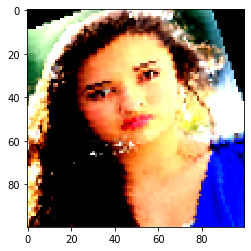

In [21]:
plt.imshow(image.squeeze().numpy().transpose(1,2,0))

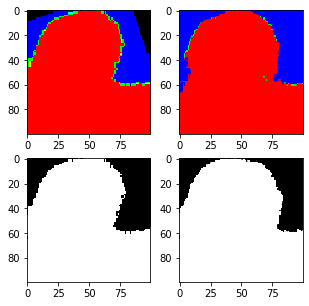

In [22]:
f, axarr = plt.subplots(2,2,figsize=(5,5))

axarr[0,0].imshow(trimap.squeeze().numpy().transpose(1,2,0))
axarr[0,1].imshow(trimap_1.cpu().squeeze().numpy().transpose(1,2,0))
axarr[1,0].imshow(matte.squeeze().numpy(),cmap="gray")
axarr[1,1].imshow(matte_1.cpu().squeeze().numpy(),cmap="gray")

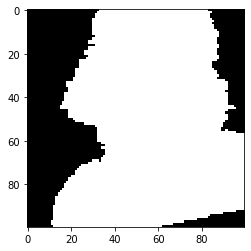

In [62]:
plt.imshow(matte.squeeze().numpy(),cmap='gray')

In [67]:
GNet = GluNet()
GNet.load_state_dict(torch.load(CURRENT_DIR + '/Models/Versions/COMP/GNET COMP v100'))
GNet.to(DEVICE)
with torch.no_grad():
    trimap_1, matte_1 = GNet(image.to(DEVICE))

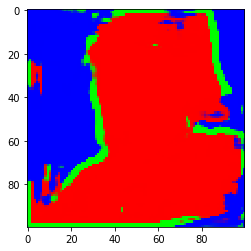

In [68]:
plt.imshow(trimap_1.cpu().squeeze().numpy().transpose(1,2,0))

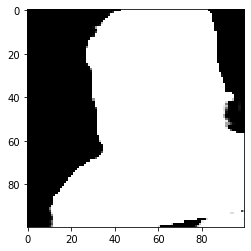

In [69]:
plt.imshow(matte_1.cpu().squeeze().numpy(),cmap='gray')

In [3]:
x = y = np.random.randint(3,5)

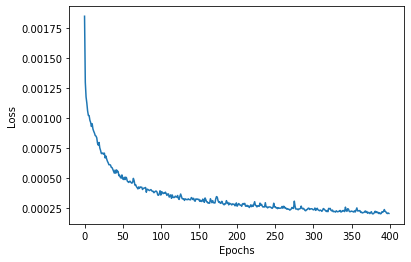

In [29]:
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss');